# Example 10: Cell Death Index

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = Client()
client

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36843 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36843/status,
Dashboard: http://127.0.0.1:36843/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44683,Workers: 8
Dashboard: http://127.0.0.1:36843/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:44603,Total threads: 4
Dashboard: http://127.0.0.1:37449/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:40743,


## Data Loading

In [3]:
CANCER_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"

In [4]:
cancer_ddf = dd.read_csv(CANCER_DATA_PATH)
cancer_ddf

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Calculate CDI for the Cancer Cell

## Intensity Normalization

In [5]:
cancer_ddf, cancer_gfp_lp, cancer_gfp_up = intensity_norm_percentile(cancer_ddf,channel="gfp_mean", percentile=1)
cancer_ddf, cancer_pi_lp, cancer_pi_up = intensity_norm_percentile(cancer_ddf,channel="pi_mean", percentile=1)

## CDI Calculation

In [6]:
cancer_ddf = calculate_cdi(cancer_ddf, viability_col="gfp_mean_norm", death_col="pi_mean_norm")
cancer_ddf

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
cancer_ddf = compute_savgol_filter(cancer_ddf, track_id_col='track_id', frame_col='frame', value_col='CDI', window_length=500, polyorder=3)
cancer_ddf

/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:334: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interpolated = ddf_sorted.groupby(track_id_col).apply(interpolate).reset_index(drop=True)
/home/jackyko/Projects/Cytotoxicity-Pipeline/cyto/postprocessing/sparse_to_sparse.py:360: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_interpolated = df_interpolated.groupby(track_id_col).apply(apply_savgol).reset_index(drop=True)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI,CDI_smoothed,CDI_grad
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
cancer_df = cancer_ddf.compute()
cancer_df

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):
/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
 

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,CDI,CDI_smoothed,CDI_grad
0,9471715,732.319588,362.113402,357,726,12,13,362.113402,732.319588,357.0,...,1919.568359,898.412682,2.230583,True,[199747 199829 200774 201175 201230],0.427590,0.055112,0.114174,0.156603,0.000478
1,13825533,752.529412,309.794118,304,746,12,14,309.794118,752.529412,304.0,...,707.343750,445.746067,4.160336,True,[11933],0.172863,0.066832,0.278823,0.338232,0.000012
2,22869311,832.245981,635.035370,623,816,27,33,635.035370,832.245981,623.0,...,2787.146484,1871.182974,2.613589,True,[219645 220002 220044 221360 222007 222700 223...,0.748258,0.336845,0.310427,0.345928,0.001635
3,23048512,742.180952,197.390476,192,737,12,11,197.390476,742.180952,192.0,...,343.162109,446.462422,1.240649,True,[101505 103685],0.123780,0.046452,0.272873,0.294915,0.000172
4,28499271,158.166667,94.857143,90,152,10,13,94.857143,158.166667,90.0,...,145.611328,12.367833,1.907888,True,[292526 293227 295831],0.001398,0.114771,0.987965,0.989658,0.000035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146856,14405718,442.076923,483.048077,477,437,12,11,483.048077,442.076923,477.0,...,511.183594,245.853286,9.612168,False,[],0.106791,0.008883,0.076794,0.080578,0.000432
146857,15490470,440.602410,958.000000,953,435,11,11,958.000000,440.602410,953.0,...,178.560547,24.535850,0.693418,True,[210386],0.020317,0.048741,0.705796,0.704304,0.000049
146858,20038503,41.366906,57.215827,53,32,10,19,57.215827,41.366906,53.0,...,237.085938,55.574544,9.673356,False,[],0.030589,0.010010,0.246553,0.240073,0.002925
146859,13647591,216.384615,328.376923,322,209,13,15,328.376923,216.384615,322.0,...,889.052734,579.158515,2.877476,True,[133241 134683],0.253169,0.041173,0.139881,0.159029,-0.001242


## Plot CDI vs Time

### Single Cell

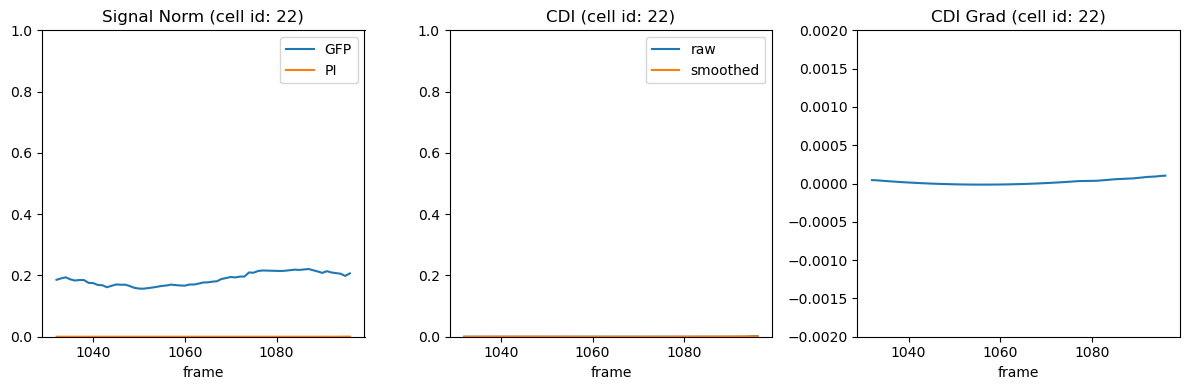

In [9]:
track_id = 22

res = cancer_df[cancer_df["track_id"]==track_id]
res = res.sort_values(by="frame")

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].plot(res["frame"], res["gfp_mean_norm"],label="GFP")
axs[0].plot(res["frame"], res["pi_mean_norm"], label="PI")
axs[0].set_title("Signal Norm (cell id: {})".format(track_id))
axs[0].set_ylim([0,1])
axs[0].set_xlabel("frame")
axs[0].legend()

axs[1].plot(res["frame"], res["CDI"],label="raw")
axs[1].plot(res["frame"], res["CDI_smoothed"], label="smoothed")
axs[1].set_title("CDI (cell id: {})".format(track_id))
axs[1].set_ylim([0,1])
axs[1].set_xlabel("frame")
axs[1].legend()

axs[2].plot(res["frame"], res["CDI_grad"],label="raw")
axs[2].set_title("CDI Grad (cell id: {})".format(track_id))
axs[2].set_xlabel("frame")
axs[2].set_ylim([-2e-3,2e-3])

fig.tight_layout()

### Ensemble

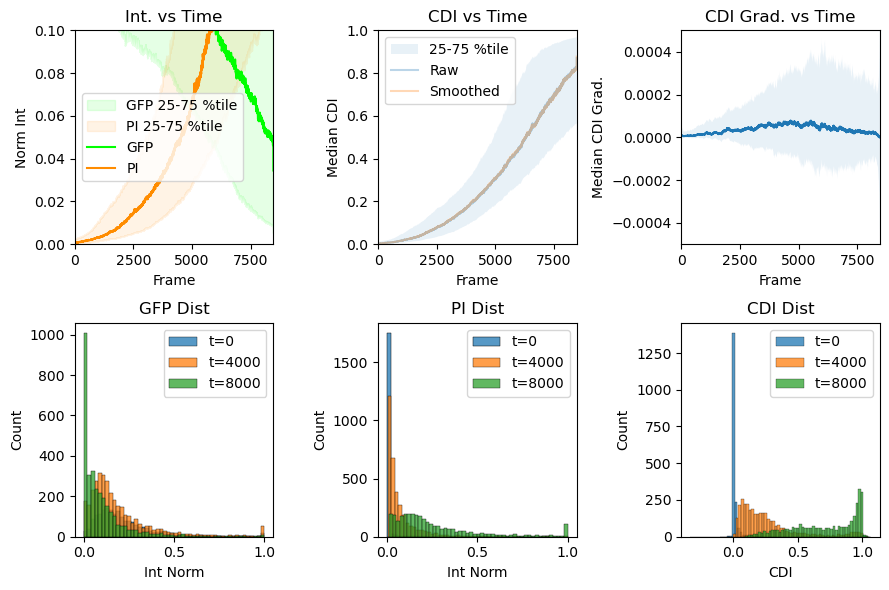

In [10]:
fig, axs = plt.subplots(2,3,figsize=(9,6))

def calc_percentiles(group):
    return pd.Series({
        '25th_percentile': group.quantile(0.25),
        '75th_percentile': group.quantile(0.75),
    })

######## Intensity ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['gfp_mean_norm'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,0].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, color='lime', label='GFP 25-75 %tile')

# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['pi_mean_norm'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index
axs[0,0].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, color='darkorange', label='PI 25-75 %tile')

axs[0,0].plot(cancer_df.groupby('frame')['gfp_mean_norm'].median(), label="GFP", c="lime")
axs[0,0].plot(cancer_df.groupby('frame')['pi_mean_norm'].median(), label="PI", c="darkorange")
axs[0,0].set_xlim(0,cancer_df["frame"].max() )
axs[0,0].set_ylim(0,0.1)
axs[0,0].set_ylabel("Norm Int")
axs[0,0].set_xlabel("Frame")
axs[0,0].set_title("Int. vs Time")
axs[0,0].legend()

######## CDI ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['CDI_smoothed'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,1].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, label='25-75 %tile')
axs[0,1].plot(cancer_df.groupby('frame')['CDI'].median(),label="Raw", alpha=0.3)
axs[0,1].plot(cancer_df.groupby('frame')['CDI_smoothed'].median(),label="Smoothed", alpha=0.3)
axs[0,1].set_ylabel("Median CDI")
axs[0,1].set_xlabel("Frame")
axs[0,1].set_title("CDI vs Time")
axs[0,1].set_xlim(0,cancer_df["frame"].max())
axs[0,1].set_ylim(0,1)
axs[0,1].legend()

####### CDI gradient ########
# Group the data by date and apply the percentile calculations
grouped = cancer_df.groupby('frame')['CDI_grad'].apply(calc_percentiles).unstack()

# Sort the groups by date (already sorted by time if time is continuous)
grouped_sorted = grouped.sort_index()

# x-axis will be the time (date in this case)
x = grouped_sorted.index

# Filling between 25th and 75th percentiles
axs[0,2].fill_between(x, grouped_sorted['25th_percentile'], grouped_sorted['75th_percentile'], 
                 alpha=0.1, label='25-75 %tile')
axs[0,2].plot(cancer_df.groupby('frame')['CDI_grad'].median())
axs[0,2].set_ylabel("Median CDI Grad.")
axs[0,2].set_xlabel("Frame")
axs[0,2].set_title("CDI Grad. vs Time")
axs[0,2].set_xlim(0,cancer_df["frame"].max() )
axs[0,2].set_ylim(-5e-4,5e-4)

####### histograms ########
axs[1,0].set_title("GFP Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['gfp_mean_norm'], binwidth=0.02, label="t=0", ax=axs[1,0])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['gfp_mean_norm'], binwidth=0.02, label="t=4000", ax=axs[1,0])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['gfp_mean_norm'], binwidth=0.02, label="t=8000", ax=axs[1,0])
axs[1,0].legend()
axs[1,0].set_xlabel("Int Norm")

axs[1,1].set_title("PI Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['pi_mean_norm'], binwidth=0.02, label="t=0", ax=axs[1,1])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['pi_mean_norm'], binwidth=0.02, label="t=4000", ax=axs[1,1])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['pi_mean_norm'], binwidth=0.02, label="t=8000", ax=axs[1,1])
axs[1,1].legend()
axs[1,1].set_xlabel("Int Norm")

axs[1,2].set_title("CDI Dist")
sns.histplot(cancer_df[cancer_df["frame"]==0]['CDI_smoothed'], binwidth=0.02, label="t=0", ax=axs[1,2])
sns.histplot(cancer_df[cancer_df["frame"]==4000]['CDI_smoothed'], binwidth=0.02, label="t=4000", ax=axs[1,2])
sns.histplot(cancer_df[cancer_df["frame"]==8000]['CDI_smoothed'], binwidth=0.02, label="t=8000", ax=axs[1,2])
axs[1,2].legend()
axs[1,2].set_xlabel("CDI")

plt.tight_layout()